In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytz

from datetime import datetime
from scipy import stats

import seaborn as sns; sns.set()

In [2]:
pings = pd.read_csv('data/pings.csv')
pings['date'] = pd.to_datetime(pings['ping_timestamp'], unit='s')
pings['date'] = pings['date'].dt.tz_localize('Asia/Jakarta')
pings['day'] = pings['date'].dt.day
pings['hour'] = pings['date'].dt.hour
pings = pings.sort_values(by=['driver_id', 'ping_timestamp'])

In [3]:
def get_online_hours(df, th=8):
    df['diff'] = df.groupby(['driver_id', 'day'])['ping_timestamp'].diff(1)
    df['diff'] = df['diff'].fillna(0)//15
    df['online'] = df['diff']
    
    threshold_candidate = df[['diff']]
    df.loc[df.online > th, 'online'] = 0
    
    df_result = df.groupby(['driver_id', 'day'])['online'].sum()
    df_result = df_result.reset_index()
    df_result['online_hours'] = df_result['online']/(4*60) 
    
    df_result['date'] = pd.to_datetime(df_result.day, unit='D', origin=pd.Timestamp('2017-05-31'))
    return df_result, threshold_candidate

In [4]:
result, threshold_candidate = get_online_hours(pings, th=8)

In [5]:
result = result.drop(['online'], axis=1)
result.to_csv('data/train.csv', index=False)

# Selecting best threshold 

In [15]:
# less than 60 minutes
candidate = threshold_candidate[threshold_candidate['diff'] < 240].drop_duplicates()
candidate = candidate.sort_values('diff').reset_index(drop=True)
candidate = candidate.reset_index()

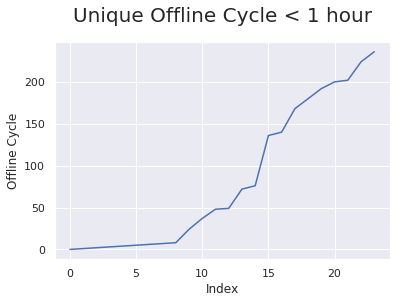

In [16]:
plt.plot(candidate['index'], candidate['diff'])
plt.title('Unique Offline Cycle < 1 hour',fontsize=20, pad=20)
plt.xlabel('Index')
plt.ylabel('Offline Cycle')
plt.show()

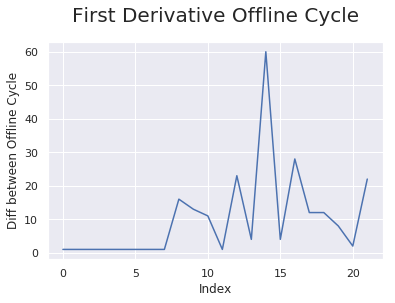

In [17]:
first_derivative = candidate['diff'].values[1:-1]-candidate['diff'].values[:-2]
plt.plot(np.arange(len(first_derivative)), first_derivative)
plt.title('First Derivative Offline Cycle',fontsize=20, pad=20)
plt.xlabel('Index')
plt.ylabel('Diff between Offline Cycle')
plt.show()

In [9]:
max_diff = np.argmax(first_derivative)
candidate['diff'][max_diff-1:max_diff+2]

50527329     72.0
50527330     76.0
50527331    136.0
Name: diff, dtype: float64

# Cross check 

In [18]:
result[result.online_hours == 1].head(1)

,driver_id,day,online_hours,date
3264,187398,14,1.0,2017-06-14


In [19]:
print('online hours in minutes based on ping', pings[(pings.driver_id==187398)&(pings.day==14)]['online'].count()/4)
print('calculated online hours in minutes', pings[(pings.driver_id==187398)&(pings.day==14)]['online'].sum()/4)

online hours in minutes based on ping 56.0
calculated online hours in minutes 60.0
